# Top 10 Restuarants in 8 Boroughs of Toronto by Rating and Likes

## Import Libraries

In [98]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import matplotlib.font_manager

import requests
from geopy.geocoders import Nominatim, requests, folium
from pandas.io.json import json_normalize

import folium

## Use pandas to scrape the Wikipedia page - Toronto's Postal Codes, Canada

First, define url, then use pd.read_html(url) to get data. This funtion will return data from table in Wikipedia page. In this case, the page has two tables. Data is return as a list. the first element in the list is the one.

In [4]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [6]:
toronto_postal = pd.read_html(wiki_url)[0]

In [7]:
print(toronto_postal.shape)
toronto_postal.head(5)

(180, 3)


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Filter out 'Not assigned'. 

In [8]:
toronto_postal = toronto_postal[toronto_postal['Neighbourhood'] != 'Not assigned']

In [9]:
print(toronto_postal.shape)
toronto_postal.head()

(103, 3)


,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## Create Dataframe with Latitude and Longtitude

### Get Geospatial Coordinates
I use Geospatial_Coordinates.csv file for Latitude and Longtitude. After that, I merge the data with <b> toronto_postal </b>.

In [10]:
toronto_geo_coords = pd.read_csv('Geospatial_Coordinates.csv')

In [11]:
toronto_geo_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge Geospatial Coordinates with Toronto Postal

In [12]:
# toronto_nb = toronto neighbours
toronto_nb = pd.merge(toronto_postal, toronto_geo_coords, how='inner', on='Postal Code') 

In [13]:
toronto_nb.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [14]:
toronto_nb.shape

(103, 5)

## Explore Restaurants in Toronto, Canada

### Use Foursquare API to explore restaurants in all neighborhoods

#### Define Foursquare Credentials and Version

In [20]:
CLIENT_ID = 'PPJZU5DJCESX03USVZX5AGZ0BLFHHBVVW3Z40MMFQV0TEPLD' # your Foursquare ID
CLIENT_SECRET = 'Z1IB55F2HM112MI42S2PH5MQUQ01SKRKB3DIOIB3IOV2DJOH' # your Foursquare Secret
ACCESS_TOKEN = 'OTCBV5CCPX3UXFC3MHISSPXSQTQIM5TLWSJCX0W5GTALW3EF' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PPJZU5DJCESX03USVZX5AGZ0BLFHHBVVW3Z40MMFQV0TEPLD
CLIENT_SECRET:Z1IB55F2HM112MI42S2PH5MQUQ01SKRKB3DIOIB3IOV2DJOH


#### Explore venues in all neighbourhoods, Toronto

Let's create a function to create explore venues in all neighborhoods in Toronto that we have in <b>toronto_nb</b>. But frist, let's look at <b>toronto_nb</b> once again 

In [23]:
toronto_nb.head(15)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


There are some duplications in <b>Neighbourhood</b> columns. For example, <b> Don Mills </b> has more than one postal code, and it has different Latitude and Longitude. I made modification to <b>getNearbyVenues()</b> function to differentiate a<b> neighbourhood</b> with the same name but has different <b> postal code and Latitude and Longitude </b> by adding postal code to neighbourhood value.

In [25]:
# explore all Toronto neighborhoods
def getNearbyVenues(boroughs, names, latitudes, longitudes, postal_codes, radius=500):
        
    venues_list=[]
    for borough, name, lat, lng, postal_code in zip(boroughs, names, latitudes, longitudes, postal_codes):

        print(name + ',', postal_code)
                
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name + ', ' + postal_code, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                'Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude',
                   'Venue ID', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
toronto_venues = getNearbyVenues(boroughs=toronto_nb['Borough'],
                                names=toronto_nb['Neighbourhood'],
                                   latitudes=toronto_nb['Latitude'],
                                   longitudes=toronto_nb['Longitude'],
                                    postal_codes=toronto_nb['Postal Code']
                                  )

Parkwoods, M3A
Victoria Village, M4A
Regent Park, Harbourfront, M5A
Lawrence Manor, Lawrence Heights, M6A
Queen's Park, Ontario Provincial Government, M7A
Islington Avenue, Humber Valley Village, M9A
Malvern, Rouge, M1B
Don Mills, M3B
Parkview Hill, Woodbine Gardens, M4B
Garden District, Ryerson, M5B
Glencairn, M6B
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale, M9B
Rouge Hill, Port Union, Highland Creek, M1C
Don Mills, M3C
Woodbine Heights, M4C
St. James Town, M5C
Humewood-Cedarvale, M6C
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood, M9C
Guildwood, Morningside, West Hill, M1E
The Beaches, M4E
Berczy Park, M5E
Caledonia-Fairbanks, M6E
Woburn, M1G
Leaside, M4G
Central Bay Street, M5G
Christie, M6G
Cedarbrae, M1H
Hillcrest Village, M2H
Bathurst Manor, Wilson Heights, Downsview North, M3H
Thorncliffe Park, M4H
Richmond, Adelaide, King, M5H
Dufferin, Dovercourt Village, M6H
Scarborough Village, M1J
Fairview, Henry Farm, Oriole, M2J
Northwood Park, Yo

In [29]:
print(toronto_venues.shape)
toronto_venues.head()

(2115, 9)


,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,"Parkwoods, M3A",43.753259,-79.329656,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,43.751976,-79.332140,Park
1,North York,"Parkwoods, M3A",43.753259,-79.329656,51d769f2498e3efc78bee6b9,649 Variety,43.754513,-79.331942,Convenience Store
2,North York,"Parkwoods, M3A",43.753259,-79.329656,4cb11e2075ebb60cd1c4caad,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,North York,"Victoria Village, M4A",43.725882,-79.315572,4c633acb86b6be9a61268e34,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,North York,"Victoria Village, M4A",43.725882,-79.315572,4f3ecce6e4b0587016b6f30d,Portugril,43.725819,-79.312785,Portuguese Restaurant


### Get all restaurants in Toronto

Now we have venues. Let's filter out Toronto venues, and take just restaurants. After that, we explore the detail of all resturants.

#### Filter toronto_venues to get all resturants
To do this, we need to get venue category with the word <b> Restuarant </b> because there are many different resturants.

In [34]:
toronto_restaurants = toronto_venues[toronto_venues['Venue Category'].str.contains('Restaurant')]

In [35]:
print(toronto_restaurants.shape)
toronto_restaurants.head()

(478, 9)


,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
4,North York,"Victoria Village, M4A",43.725882,-79.315572,4f3ecce6e4b0587016b6f30d,Portugril,43.725819,-79.312785,Portuguese Restaurant
12,Downtown Toronto,"Regent Park, Harbourfront, M5A",43.654260,-79.360636,5612b1cc498e3dd742af0dc8,Impact Kitchen,43.656369,-79.356980,Restaurant
28,Downtown Toronto,"Regent Park, Harbourfront, M5A",43.654260,-79.360636,53a22c92498ec91fda7ce133,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
45,Downtown Toronto,"Regent Park, Harbourfront, M5A",43.654260,-79.360636,50e88fc6e4b007fcbb57aae8,Izumi,43.649970,-79.360153,Asian Restaurant
54,North York,"Lawrence Manor, Lawrence Heights, M6A",43.718518,-79.464763,4ccc5aebee23a14370591ea8,Lac Vien Vietnamese Restaurant,43.721259,-79.468472,Vietnamese Restaurant


####  Visualize total resturants in each borough

To visualize all resturants in each borough, we need to group them by borough. But before we do so, let's check for Venue duplication, because one restaurant might belong to more than one neighbourhoods (some restaurants might not be far from some neighbourhoods).

In [55]:
toronto_restaurants = toronto_restaurants.drop_duplicates(subset=['Venue'])

In [56]:
toronto_restaurants.shape

(347, 9)

In [57]:
borough_restaurants = toronto_restaurants.groupby(by='Borough', as_index=False).agg({'Venue Category': pd.Series.nunique})

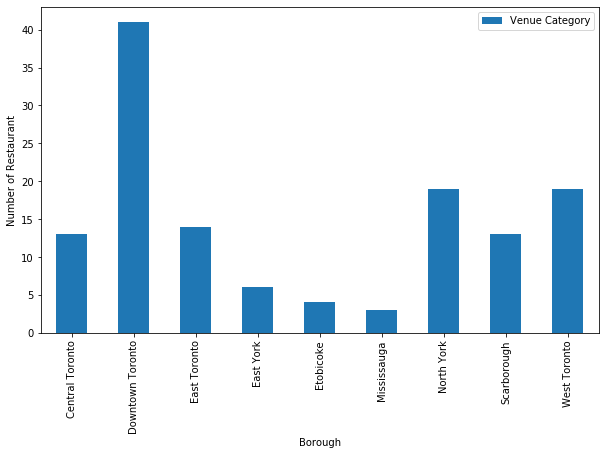

In [59]:
fig, ax = plt.subplots()
ax.set_ylabel('Number of Restaurant')
ax.set_xlabel('Borough')
borough_restaurants.plot(kind='bar', x='Borough', y='Venue Category', ax=ax, figsize=(10,6))
plt.show()

So, there are less than 10 restaurants in some boroughs. In that case, I will just call them top restaurants instead of top 10 restaurants.

#### let's explore Restaurant detail
Use Foursquare API to get restaurant detail by using <b> Venue ID </b> that we have in toronto_restaurants. From the API results, I take Address, Phone Number, number of like, Rating and number of tip.

Let's define a function that return a dataframe of restaurant detail.

In [46]:
def get_venue_details(venue_ids):
    
    venues_detail=[]
    
    for venue_id in venue_ids:
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        
        # get all the data
        results = requests.get(url).json()        
        
        try:
            venue_data = results['response']['venue']
            
            id_ = venue_data['id'] 
            address = venue_data['location']['formattedAddress'][0] 
            phone = venue_data['contact']['formattedPhone'] 
            likes = venue_data['likes']['count'] 
            rating = venue_data['rating'] 
            tips = venue_data['tips']['groups'][0]['count']
            #tip = venue_data['tips']['groups'][0]['items'][0]['text']
            
            venues_detail.append([(id_, address, phone, likes, rating, tips)])
        except:
            pass
    
        
    venues_detail_df = pd.DataFrame([item for venue_detail in venues_detail for item in venue_detail])
    
    venues_detail_df.columns = ['Venue ID', 'Address', 'Phone Number', 'Likes', 'Rating', 'Tips']
   
    
    return venues_detail_df

In [47]:
#this will takes minutes
resturants_detail = get_venue_details(toronto_restaurants['Venue ID'])

In [64]:
print(resturants_detail.shape)
resturants_detail.head()

(362, 6)


,Venue ID,Address,Phone Number,Likes,Rating,Tips
0,4f3ecce6e4b0587016b6f30d,1733 Eglinton Avenue East (Bermondsey),(416) 261-0010,6,6.8,12
1,5612b1cc498e3dd742af0dc8,573 King St E (at St Lawrence St),(416) 306-1986,51,8.8,9
2,53a22c92498ec91fda7ce133,35 Tank House Lane,(416) 203-2632,190,8.4,57
3,4ccc5aebee23a14370591ea8,141 Cartwright Ave,(647) 344-7933,28,7.6,12
4,52d884c5498ecf5c7cafe5ab,832 Bay St (Grenville St),(416) 925-8888,176,8.0,52


#### Total restaurants in all neighbourhoods
Let's merge toronto_restaurants with resturants_detail to information we need for restaurants in each neighbourhood.

In [73]:
toronto_restaurants_detail = toronto_restaurants.merge(resturants_detail, on='Venue ID', how='inner')

In [77]:
print(toronto_restaurants_detail.shape)
toronto_restaurants_detail.head()

(254, 14)


,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Address,Phone Number,Likes,Rating,Tips
0,North York,"Victoria Village, M4A",43.725882,-79.315572,4f3ecce6e4b0587016b6f30d,Portugril,43.725819,-79.312785,Portuguese Restaurant,1733 Eglinton Avenue East (Bermondsey),(416) 261-0010,6,6.8,12
1,Downtown Toronto,"Regent Park, Harbourfront, M5A",43.654260,-79.360636,5612b1cc498e3dd742af0dc8,Impact Kitchen,43.656369,-79.356980,Restaurant,573 King St E (at St Lawrence St),(416) 306-1986,51,8.8,9
2,Downtown Toronto,"Regent Park, Harbourfront, M5A",43.654260,-79.360636,53a22c92498ec91fda7ce133,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant,35 Tank House Lane,(416) 203-2632,190,8.4,57
3,North York,"Lawrence Manor, Lawrence Heights, M6A",43.718518,-79.464763,4ccc5aebee23a14370591ea8,Lac Vien Vietnamese Restaurant,43.721259,-79.468472,Vietnamese Restaurant,141 Cartwright Ave,(647) 344-7933,28,7.6,12
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government, M7A",43.662301,-79.389494,52d884c5498ecf5c7cafe5ab,Nando's,43.661728,-79.386391,Portuguese Restaurant,832 Bay St (Grenville St),(416) 925-8888,176,8.0,52


### Get Top 10 restaurants in each borough based on Rating and Likes

With data we have, some boroughs don't even have 10 restaurants. When we visualize restaurants in these boroughs, I decide to call them just top restaurants.

Let's sort dataframe by Rating and Likes, and then group them in each borough.

In [80]:
restaurants_detail_ordered = toronto_restaurants_detail.sort_values(by=['Rating', 'Likes'], ascending=False)
top_10_restaurants = restaurants_detail_ordered.groupby(by='Borough').head(10)

In [88]:
print(top_10_restaurants.shape)
top_10_restaurants.head()

(65, 14)


,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Address,Phone Number,Likes,Rating,Tips
85,Downtown Toronto,"Richmond, Adelaide, King, M5H",43.650571,-79.384568,529612de11d2ab526191ccc9,Pai,43.647923,-79.388579,Thai Restaurant,18 Duncan St (Adelaide and Duncan),(416) 901-4724,687,9.2,207
202,Downtown Toronto,"Kensington Market, Chinatown, Grange Park, M5T",43.653206,-79.400049,50427a03e4b08d9f5931f593,Seven Lives - Tacos y Mariscos,43.654418,-79.400545,Mexican Restaurant,69 Kensington Ave (Baldwin St),(416) 393-4636,300,9.0,102
86,Downtown Toronto,"Richmond, Adelaide, King, M5H",43.650571,-79.384568,5321f4d9e4b07946702e6e08,Byblos Toronto,43.647615,-79.388381,Mediterranean Restaurant,11 Duncan Street,(647) 660-0909,247,9.0,86
188,Downtown Toronto,"University of Toronto, Harbord, M5S",43.662696,-79.400049,527d450111d25050de4ea0d8,Rasa,43.662757,-79.403988,Restaurant,196 Robert Street,(647) 350-8221,79,9.0,38
117,West Toronto,"Little Portugal, Trinity, M6J",43.647927,-79.419750,4ada6d8df964a520832221e3,Union Restaurant,43.645860,-79.419532,New American Restaurant,72 Ossington Ave. (Queen St. W),(416) 850-0093,180,8.9,59


###  Visualize Top/Top 10 Restaurants in Each Borough

let's check all boroughs. After that, we take restaurants that are in each borough.

In [89]:
top_10_restaurants['Borough'].unique()

array(['Downtown Toronto', 'West Toronto', 'East Toronto',
       'Central Toronto', 'North York', 'Scarborough', 'East York',
       'Etobicoke'], dtype=object)

In [90]:
downtown_toronto_top_10_restaurants = top_10_restaurants[top_10_restaurants['Borough'] == 'Downtown Toronto']
west_toronto_top_10_restaurants = top_10_restaurants[top_10_restaurants['Borough'] == 'West Toronto']
east_toronto_top_10_restaurants = top_10_restaurants[top_10_restaurants['Borough'] == 'East Toronto']
central_toronto_top_10_restaurants = top_10_restaurants[top_10_restaurants['Borough'] == 'Central Toronto']
north_york_top_10_restaurants = top_10_restaurants[top_10_restaurants['Borough'] == 'North York']
scarborough_top_10_restaurants = top_10_restaurants[top_10_restaurants['Borough'] == 'Scarborough']
east_york_top_10_restaurants = top_10_restaurants[top_10_restaurants['Borough'] == 'East York']
etobicoke_top_10_restaurants = top_10_restaurants[top_10_restaurants['Borough'] == 'Etobicoke']

Create a function to create visulizations

In [91]:
def barchart_top10(data, title, figsize=(13,7), width=0.6):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    data[['Venue','Likes', 'Rating']].plot(kind='bar', width=width, ax=ax)

    for p in ax.patches: 
        width,height=p.get_width(),p.get_height() 
        x,y=p.get_xy() 
        ax.annotate('{}'.format(height),(x-0.008,y+height+0.3), fontsize=14) 

    ax.spines['right'].set_visible(False) 
    ax.spines['top'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['bottom'].set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

    ax.set_title(label=title, fontdict={'fontsize':16})
    ax.set_xticklabels(labels=data['Venue'], Fontsize=14)
    ax.legend(fontsize=14)

    plt.show()

#### Downtown Toronto

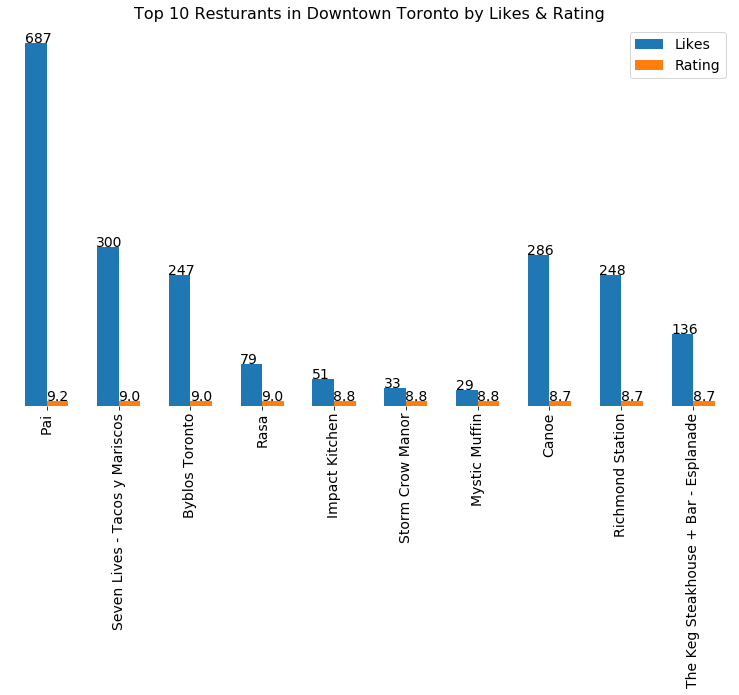

In [92]:
barchart_top10(data=downtown_toronto_top_10_restaurants, title='Top 10 Resturants in Downtown Toronto by Likes & Rating')

#### West Town

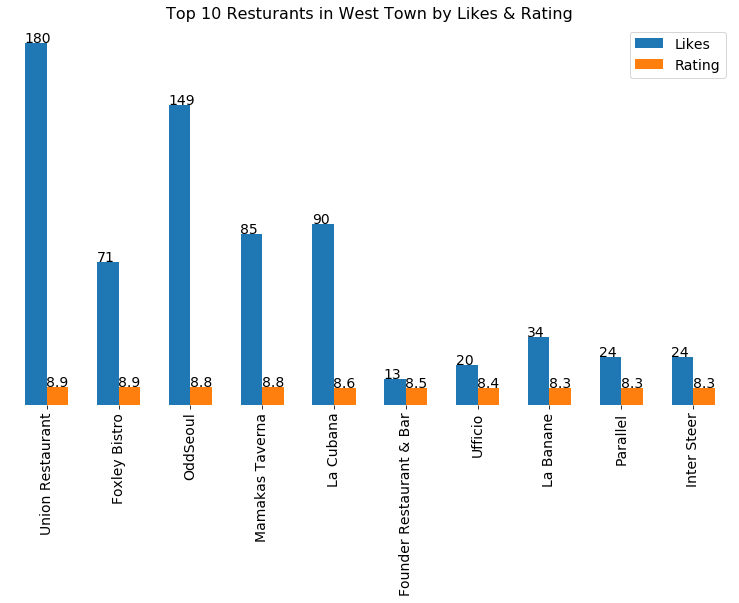

In [93]:
barchart_top10(data=west_toronto_top_10_restaurants, title='Top 10 Resturants in West Town by Likes & Rating')

#### East Town

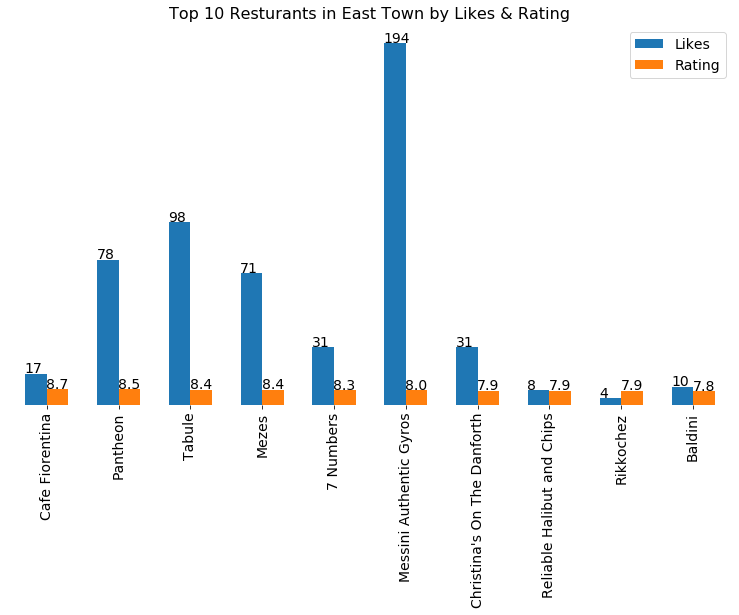

In [94]:
barchart_top10(data=east_toronto_top_10_restaurants, title='Top 10 Resturants in East Town by Likes & Rating')

#### Central Toronto

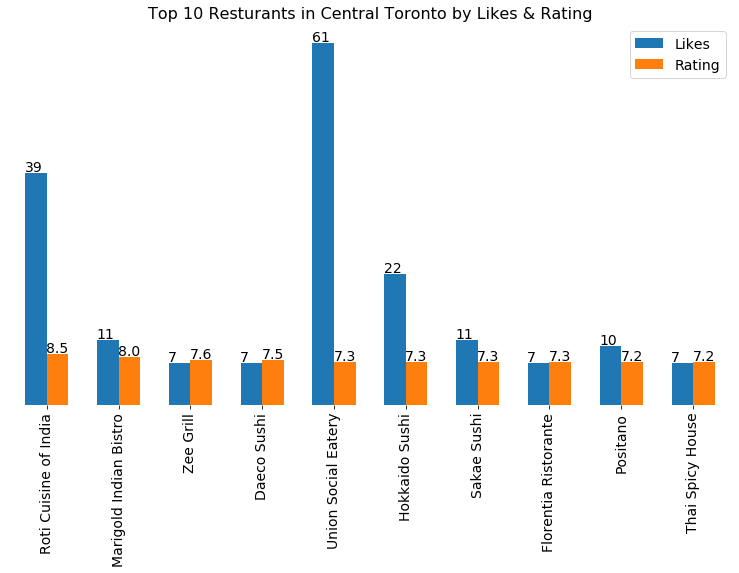

In [95]:
barchart_top10(data=central_toronto_top_10_restaurants, title='Top 10 Resturants in Central Toronto by Likes & Rating')

#### North York

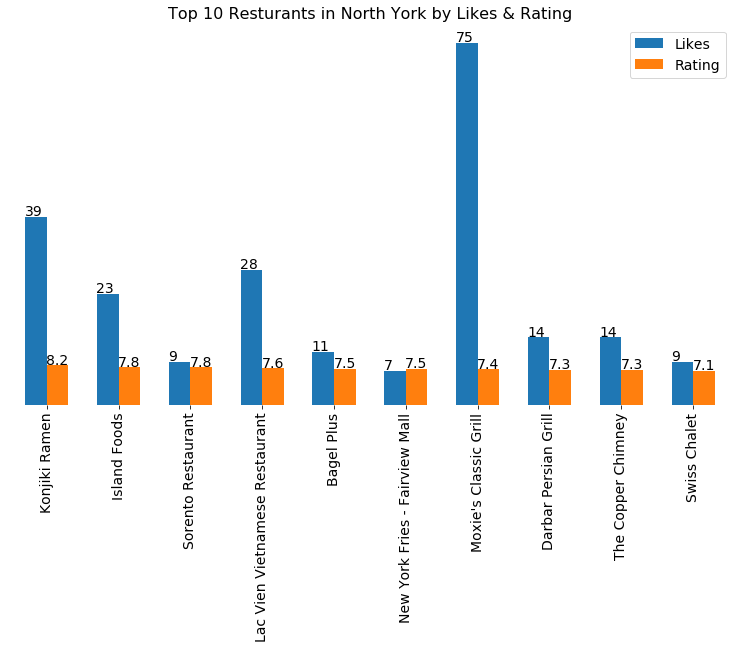

In [99]:
barchart_top10(data=north_york_top_10_restaurants, title='Top 10 Resturants in North York by Likes & Rating')

#### Scarborough

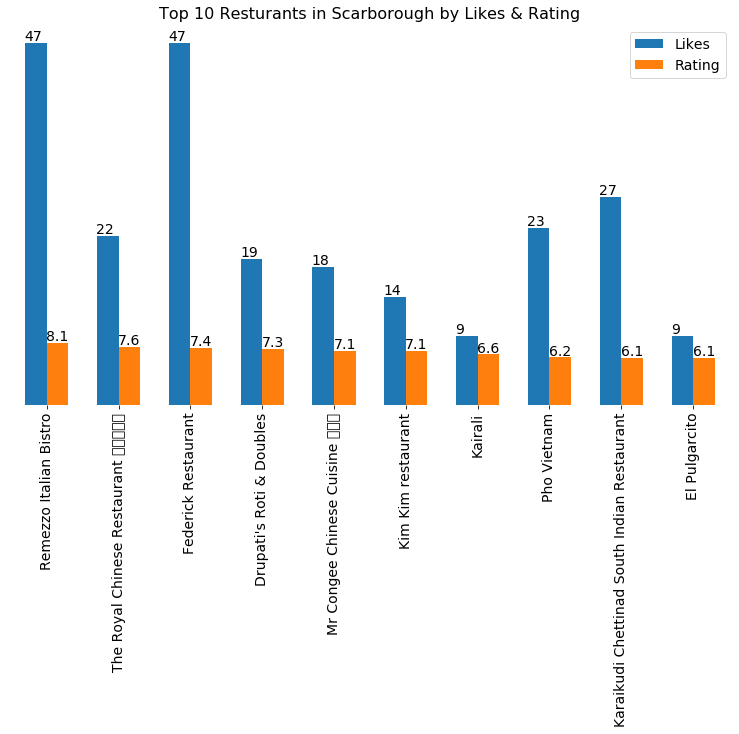

In [100]:
barchart_top10(data=scarborough_top_10_restaurants, title='Top 10 Resturants in Scarborough by Likes & Rating')

#### East York

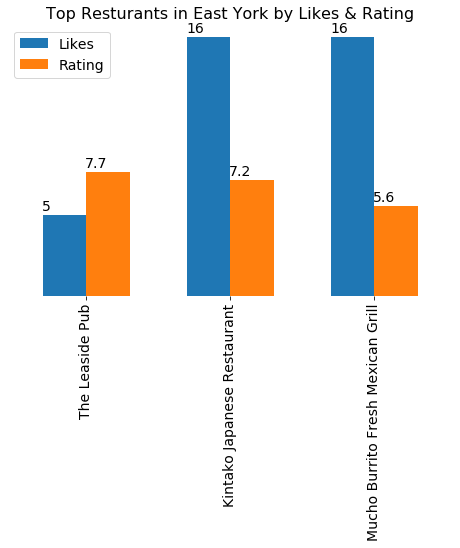

In [105]:
barchart_top10(data=east_york_top_10_restaurants, title='Top Resturants in East York by Likes & Rating', figsize=(8,5))

#### Etobicoke

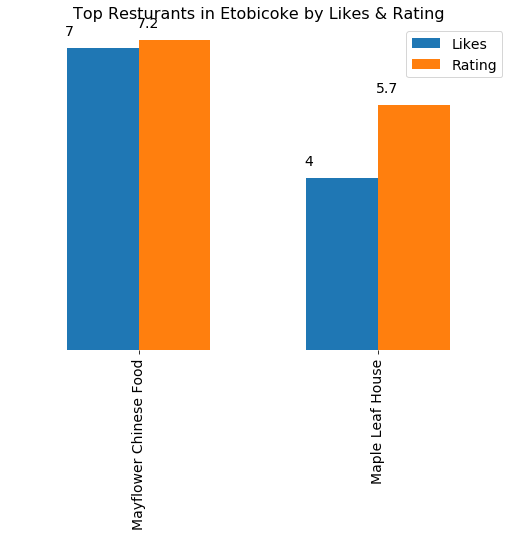

In [136]:
barchart_top10(data=etobicoke_top_10_restaurants, title='Top Resturants in Etobicoke by Likes & Rating', figsize=(9,6))

### Visualize Top/Top 10 Restaurants in Each Borough on the map

Finally, let's get Toronto latitude and longitude then visualize all restaurants on the map

In [138]:
location = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer", timeout=100)
location = geolocator.geocode(location)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(location, latitude, longitude))

The geograpical coordinate of Toronto, Golden Horseshoe, Ontario, Canada are 43.6534817, -79.3839347.


In [139]:
# create map
map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, venue, cate, rating, likes in zip(top_10_restaurants['Venue Latitude'], top_10_restaurants['Venue Longitude'], top_10_restaurants['Venue'], top_10_restaurants['Venue Category'], top_10_restaurants['Rating'], top_10_restaurants['Likes']):
    label = folium.Popup('{} (Rating: {}, Likes: {})'.format(venue, rating, likes), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_restaurants)

In [143]:
map_restaurants

## This is the end of the notebook. Thanks.